# 4.3 Implementation
## for K = 2: Grid search on the number or nuerons, number of hidden layers and the learning rate of ADAM optimizer


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from functions import *
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


K=2
N_x=10000 #number of samples
N_mu=5 #number of parameters
N_h=39
trial = str(N_h)
M=N_h
h=1/(N_h+1)
H = np.arange(1, N_h+1)*h

nbr_HL=[1, 2, 3, 10, 20, 50] #number of hidden layers
nbr_neurons=[5, 10, 25, 50, 75, 100] #number of neurons in each layer
learning_rates = [1e-5, 5 * 1e-4, 1e-4, 5 * 1e-3, 1e-3] 

# we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss()



PATH_SAVE = './grid_K=2'

cpu


## Training part
Generate the training set:

In [3]:
dataset=Inputs(N_x, N_mu, N_h, K, device)

x shape :  (10000, 5)
y shape :  (10000, 39)


In [4]:
num_epochs=50
total_samples=N_x
losses=np.zeros((len(nbr_HL), len(nbr_neurons), len(learning_rates)))
batch_size=16

for m, lr in enumerate(learning_rates):
    for j, N_HL in enumerate(nbr_HL):
        for k, N_n in enumerate(nbr_neurons):
            #declare the new model
            model = Net(N_HL, N_n, N_h, N_mu).to(device)
            #batch :
            dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            # create your optimizer
            optimizer = optim.Adam(model.parameters(), lr = lr)

            #training
            for t in range(num_epochs):
                for i, (inputs, outputs) in enumerate(dataloader):
                    y_pred = model(inputs)
                    loss = loss_fn(y_pred, outputs) #compute the loss

                    optimizer.zero_grad()   # zero the gradient buffers
                    loss.backward()
                        
                    optimizer.step()    # Does the update
            
            print("Number of hidden layers : ", N_HL, ", Number of neurons : ", N_n, ", loss : ", loss.item())
            losses[j,k,m]=loss.item()

            #Save the model
            PATH = PATH_SAVE + '/N_HL_' + str(N_HL) + '_NN_='+ str(N_n)+'_lr_' + str(lr) + '.pth'
            torch.save(model.state_dict(), PATH)

    #save the losses (training errors)
    np.savetxt(PATH_SAVE + "/losses_lr_" + str(lr) + ".dat", np.array(losses[:,:,m]))

Number of hidden layers :  10 , Number of neurons :  5 , loss :  0.014058923348784447
Number of hidden layers :  10 , Number of neurons :  10 , loss :  0.002413768321275711
Number of hidden layers :  10 , Number of neurons :  25 , loss :  0.001179719576612115
Number of hidden layers :  10 , Number of neurons :  50 , loss :  0.0008682316984049976
Number of hidden layers :  10 , Number of neurons :  75 , loss :  0.0012273668544366956
Number of hidden layers :  10 , Number of neurons :  100 , loss :  0.001074961619451642
Number of hidden layers :  20 , Number of neurons :  5 , loss :  0.20562751591205597
Number of hidden layers :  20 , Number of neurons :  10 , loss :  0.25514286756515503
Number of hidden layers :  20 , Number of neurons :  25 , loss :  0.013028488494455814
Number of hidden layers :  20 , Number of neurons :  50 , loss :  0.0028141653165221214
Number of hidden layers :  20 , Number of neurons :  75 , loss :  0.010592072270810604
Number of hidden layers :  20 , Number of n

## Testing part

In [6]:
for m, lr in enumerate(learning_rates):
    print("learning rate : ", lr)
    #iterate over all learning rates:
    Err_NN_mean=np.zeros((len(nbr_HL), len(nbr_neurons)))
    Err_New_mean=np.zeros((len(nbr_HL), len(nbr_neurons)))

    #number of Mu samples
    N_err=5000

    #generate Mus randomly (so that the input samples are the same for every learning rate):
    inputs=torch.zeros((N_err, N_mu))
    somme_list=[]

    #generate random Mus:
    for i in range(N_err):
        #random Mus 
        Mus=np.random.uniform(-1,1,N_mu)
        inputs[i, :]=torch.from_numpy(Mus).float()
        somme=fct(Mus, K)
        somme_list.append(somme)
        

    #compute test errors
    for j, N_HL in enumerate(nbr_HL):
        print("Number of hidden layers: ", N_HL)
        for k, N_n in enumerate(nbr_neurons):
            #define the model:
            N_HL=int(N_HL)

            #trained model:
            net=Net(N_HL, N_n, N_h, N_mu)
            PATH = PATH_SAVE + '/N_HL_' + str(N_HL) + '_NN_='+ str(N_n)+'_lr_' + str(lr) + '.pth'
            net.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
                
            Err_NN=np.zeros(N_err)
            Err_New=np.zeros(N_err)

            for i in range(N_err):
                #newmark sol:
                u_np, t = newmark(N_h, M, somme_list[i], h, h)
                u=torch.from_numpy(u_np)

                #exact sol
                uex=sol_given_fct2(somme_list[i]) 
                y_ex=torch.from_numpy(np.vectorize(uex)(H,t))

                Err_New[i]=loss_fn(y_ex, u)

                #DNN error:
                x = inputs[i, :]
                y_pred=net(x)

                Err_NN[i]=loss_fn(y_ex, y_pred)
        
            # store the mean errors:
            Err_NN_mean[j,k] = np.mean(Err_NN)
            Err_New_mean[j,k] = np.mean(Err_New)

    np.savetxt(PATH_SAVE + "/Err_NN_mean_lr = " + str(lr) + ".dat", Err_NN_mean)
    np.savetxt(PATH_SAVE + "/Err_New_mean_lr = " + str(lr) + ".dat", Err_New_mean)

learning rate :  0.005
Number of hidden layers:  1
Number of hidden layers:  2
Number of hidden layers:  3
Number of hidden layers:  10
Number of hidden layers:  20
Number of hidden layers:  50
learning rate :  0.001
Number of hidden layers:  1
Number of hidden layers:  2
Number of hidden layers:  3
Number of hidden layers:  10
Number of hidden layers:  20
Number of hidden layers:  50


Compute what is the best combination to have the lowest MSE:

In [33]:
lowest_MSE = np.zeros((len(learning_rates), 3))
for m, lr in enumerate(learning_rates):
    Err_NN_mean = np.genfromtxt(PATH_SAVE + "/Err_NN_mean_lr = " + str(lr) + ".dat")
    indices= np.unravel_index(Err_NN_mean.argmin(), Err_NN_mean.shape)
    print("best combination for lr = ", lr, " : ")
    print("Number of neurons : ", nbr_neurons[indices[1]], " and number of hidden layers : ",  nbr_HL[indices[0]])
    print("with MSE : ", Err_NN_mean[indices])
    lowest_MSE[m, 0] = Err_NN_mean[indices]
    lowest_MSE[m, 1] = int(nbr_neurons[indices[1]])
    lowest_MSE[m, 2] = int(nbr_HL[indices[0]])

print("\nBEST SCORE over all learning rates : ")
argmin = np.argmin(lowest_MSE[:,0])
print(np.min(lowest_MSE[:,0]))
print("with learning rate:", learning_rates[argmin])
print("nb neurons : ", lowest_MSE[argmin, 1])
print("nb hidden layers : ", lowest_MSE[argmin, 2])
    

best combination for lr =  1e-05  : 
Number of neurons :  100  and number of hidden layers :  3
with MSE :  6.726641676893016e-05
best combination for lr =  0.0005  : 
Number of neurons :  10  and number of hidden layers :  2
with MSE :  3.806543455138206e-09
best combination for lr =  0.0001  : 
Number of neurons :  25  and number of hidden layers :  1
with MSE :  7.297967035700017e-09
best combination for lr =  0.005  : 
Number of neurons :  25  and number of hidden layers :  1
with MSE :  2.028964822486009e-08
best combination for lr =  0.001  : 
Number of neurons :  5  and number of hidden layers :  1
with MSE :  9.016610902886525e-08

BEST SCORE over all learning rates : 
3.806543455138206e-09
with learning rate: 0.0005
nb neurons :  10.0
nb hidden layers :  2.0


Table for latex:

In [73]:
all_errors = np.zeros((len(nbr_HL), len(nbr_neurons), len(learning_rates)))
for k, lr in enumerate(learning_rates):
    all_errors[:,:,k] = np.genfromtxt(PATH_SAVE + "/Err_NN_mean_lr = " + str(lr) + ".dat")

nbr_HL=[1, 2, 3, 10, 20, 50] #number of hidden layers
nbr_neurons=[5, 10, 25, 50, 75, 100] #number of neurons in each layer
learning_rates = [1e-5, 5 * 1e-4, 1e-4, 5 * 1e-3, 1e-3] 

midx = pd.MultiIndex.from_product([nbr_HL, nbr_neurons, ],
         names=["nbr hl", "nbr neurons"])

#df = pd.DataFrame(np.random.randn(len(midx), 3), index = midx)
df = pd.DataFrame(all_errors.reshape(36, 5), index = midx, columns=learning_rates).applymap('{:.2E}'.format)
df.to_latex

<bound method NDFrame.to_latex of                      0.00001   0.00050   0.00010   0.00500   0.00100
nbr hl nbr neurons                                                  
1      5            6.79E-02  8.00E-09  3.04E-04  1.00E-06  9.02E-08
       10           3.09E-02  5.41E-08  5.64E-08  3.55E-06  2.80E-06
       25           2.41E-03  2.54E-08  7.30E-09  2.03E-08  1.05E-06
       50           5.47E-04  9.40E-09  4.06E-07  1.14E-07  4.78E-07
       75           3.64E-04  8.10E-07  9.44E-08  1.09E-07  7.63E-06
       100          2.08E-04  2.31E-08  4.86E-07  5.30E-06  2.33E-07
2      5            6.19E-02  2.77E-04  1.26E-03  1.53E-05  2.28E-07
       10           1.25E-02  3.81E-09  2.28E-07  9.62E-07  2.48E-07
       25           1.35E-03  4.76E-08  1.37E-07  1.23E-06  1.21E-06
       50           2.67E-04  1.95E-07  2.32E-07  6.41E-05  2.22E-06
       75           1.53E-04  2.04E-06  9.22E-07  2.29E-06  1.56E-07
       100          9.97E-05  3.95E-06  5.39E-06  1.49E-06  4.58E-06


Plot one solution according to the chosen parameters: 

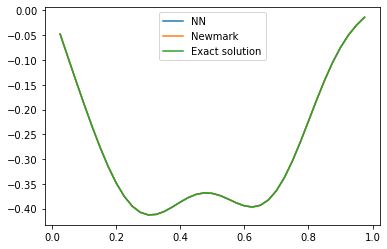

In [5]:
#choose which parameters you want to use:
lr = 1e-4
N_n=25
N_HL=1

#initialization
net=Net(N_HL, N_n, N_h, N_mu)
PATH = PATH_SAVE + '/N_HL_' + str(N_HL) + '_NN_='+ str(N_n)+'_lr_' + str(lr) + '.pth'
net.load_state_dict(torch.load(PATH, map_location = torch.device(device)))

#compute a random solution
Mus=np.random.uniform(-1,1,N_mu)
x = torch.from_numpy(Mus).float()
y_pred = net(x)
somme=fct(Mus, K = K)
uex=sol_given_fct2(somme)

u_np, t=newmark(N_h,M,somme, h, h)

y_ex=torch.from_numpy(np.vectorize(uex)(H,t))
y_ex_np=y_ex.detach().numpy()


#plot:
plot_sol(N_h, y_pred.detach().numpy())
plot_sol(N_h, u_np)
plot_sol(N_h, y_ex_np)
plt.legend(["NN","Newmark", "Exact solution"])
#plt.title("Example of numerical solutions")
plt.show()  